# Reinforcement Q-Learning
**Example Design: Self-Driving Cab**
Let's design a simulation of a self-driving cab. The major goal is to demonstrate, in a simplified environment, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:
*   Drop off the passenger to the right location.
*   Save passenger's time by taking minimum time possible to drop off
*   Take care of passenger's safety and traffic rules

**1. Rewards**
Since the agent (the imaginary driver) is reward-motivated and is going to learn how to control the cab by trial experiences in the environment, we need to decide the rewards and/or penalties and their magnitude accordingly. Here a few points to consider:


*   The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired
*   The agent should be penalized if it tries to drop off a passenger in wrong locations
*   The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible

**2. State Space**
In Reinforcement Learning, the agent encounters a state, and then takes action according to the state it's in.

The State Space is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):

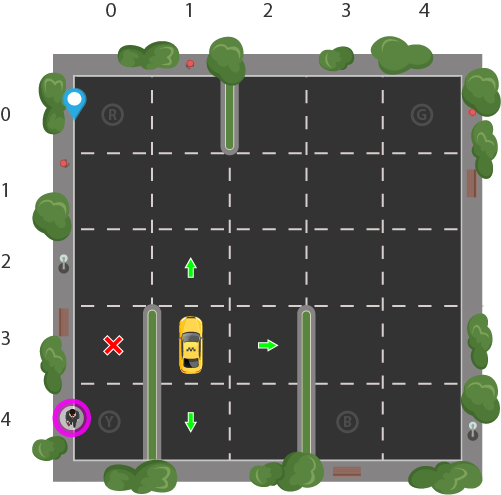

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one (1) additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's four (4) destinations and five (4 + 1) passenger locations.

So, our taxi environment has 5 x 5 x 4 =500 total possible states.

**3. Action Space**

The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger.

In other words, we have six possible actions:



1.  south
2.  north
3.  east
4.  west
5.  pickup
6.  dropoff


This is the action space: the set of all the actions that our agent can take in a given state.

The taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.





# Implementation with Python

We'll be using the Gym environment called Taxi-V2, which all of the details explained above were pulled from. The objectives, rewards, and actions are all the same.

**Gym's interface**

We need to install gym first. Executing the following in a Jupyter notebook should work:


In [ ]:
!pip install cmake 'gym[atari]' scipy

Once installed, we can load the game environment and render what it looks like:

In [ ]:
import gym

env = gym.make("Taxi-v2").env

env.render()

The core gym interface is env, which is the unified environment interface. The following are the env methods that would be quite helpful to us:

* env.reset: Resets the environment and returns a random initial state.
* env.step(action): Step the environment by one timestep. Returns
  * observation: Observations of the environment
  * reward: If your action was beneficial or not
  * done: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
  * info: Additional info such as performance and latency for debugging purposes
* env.render: Renders one frame of the environment (helpful in visualizing the environment)

**Reminder of our problem**
Here's our restructured problem statement (from Gym docs):

"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

Let's dive more into the environment.



In [ ]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

* The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
* The pipe ("|") represents a wall which the taxi cannot cross.
* R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

As verified by the prints, we have an Action Space of size 6 and a State Space of size 500. As you'll see, our RL algorithm won't need any more information than these two things. All we need is a way to identify a state uniquely by assigning a unique number to every possible state, and RL learns to choose an action number from 0-5 where:

* 0 = south
* 1 = north
* 2 = east
* 3 = west
* 4 = pickup
* 5 = dropoff

Recall that the 500 states correspond to a encoding of the taxi's location, the passenger's location, and the destination location.

Reinforcement Learning will learn a mapping of states to the optimal action to perform in that state by exploration, i.e. the agent explores the environment and takes actions based off rewards defined in the environment.

The optimal action for each state is the action that has the highest cumulative long-term reward.

We can actually take our illustration above, encode its state, and give it to the environment to render in Gym. Recall that we have the taxi at row 3, column 1, our passenger is at location 2, and our destination is location 0. Using the Taxi-v2 state encoding method, we can do the following:

In [ ]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

We are using our illustration's coordinates to generate a number corresponding to a state between 0 and 499, which turns out to be 328 for our illustration's state.

Then we can set the environment's state manually with env.env.s using that encoded number. You can play around with the numbers and you'll see the taxi, passenger, and destination move around.

**The Reward Table**
When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a
 matrix.

Since every state is in this matrix, we can see the default reward values assigned to our illustration's state:

In [ ]:
env.P[328]

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.

A few things to note:

* The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
* In this env, probability is always 1.0.
* The nextstate is the state we would be in if we take the action at this index of the dict
* All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
* done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

Note that if our agent chose to explore action two (2) in this state it would be going East into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.

**Solving the environment without Reinforcement Learning**
Let's see what would happen if we try to brute-force our way to solving the problem without RL.

Since we have our P table for default rewards in each state, we can try to have our taxi navigate just using that.

We'll create an infinite loop which runs until one passenger reaches one destination (one episode), or in other words, when the received reward is 20. The env.action_space.sample() method automatically selects one random action from set of all possible actions.

Let's see what happens:

In [ ]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1

    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1


print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

print_frames(frames)

Not good. Our agent takes thousands of timesteps and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. We can run this over and over, and it will never optimize. The agent has no memory of which action was best for each state, which is exactly what Reinforcement Learning will do for us.

**Enter Reinforcement Learning**
We are going to use a simple RL algorithm called Q-learning which will give our agent some memory.

**Intro to Q-learning**
Essentially, Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

In our Taxi environment, we have the reward table, P, that the agent will learn from. It does thing by looking receiving a reward for taking an action in the current state, then updating a Q-value to remember if that action was beneficial.

The values store in the Q-table are called a Q-values, and they map to a (state, action) combination.

A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. Better Q-values imply better chances of getting greater rewards.

For example, if the taxi is faced with a state that includes a passenger at its current location, it is highly likely that the Q-value for pickup is higher when compared to other actions, like dropoff or north.

Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

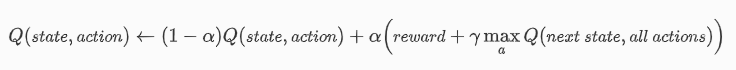
Where:

- (alpha) is the learning rate (0 < alpha <=1) - Just like in supervised learning settings,
 is the extent to which our Q-values are being updated in every iteration.

- (gamma) is the discount factor (0 <= gamma <= 1) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

**What is this saying?**

We are assigning, or updating, the Q-value of the agent's current state and action by first taking a weight (
) of the old Q-value, then adding the learned value. The learned value is a combination of the reward for taking the current action in the current state, and the discounted maximum reward from the next state we will be in once we take the current action.

Basically, we are learning the proper action to take in the current state by looking at the reward for the current state/action combo, and the max rewards for the next state. This will eventually cause our taxi to consider the route with the best rewards strung together.

The Q-value of a state-action pair is the sum of the instant reward and the discounted future reward (of the resulting state). The way we store the Q-values for each state and action is through a Q-table


**Q-Table**

The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training. Note that the Q-table has the same dimensions as the reward table, but it has a completely different purpose.
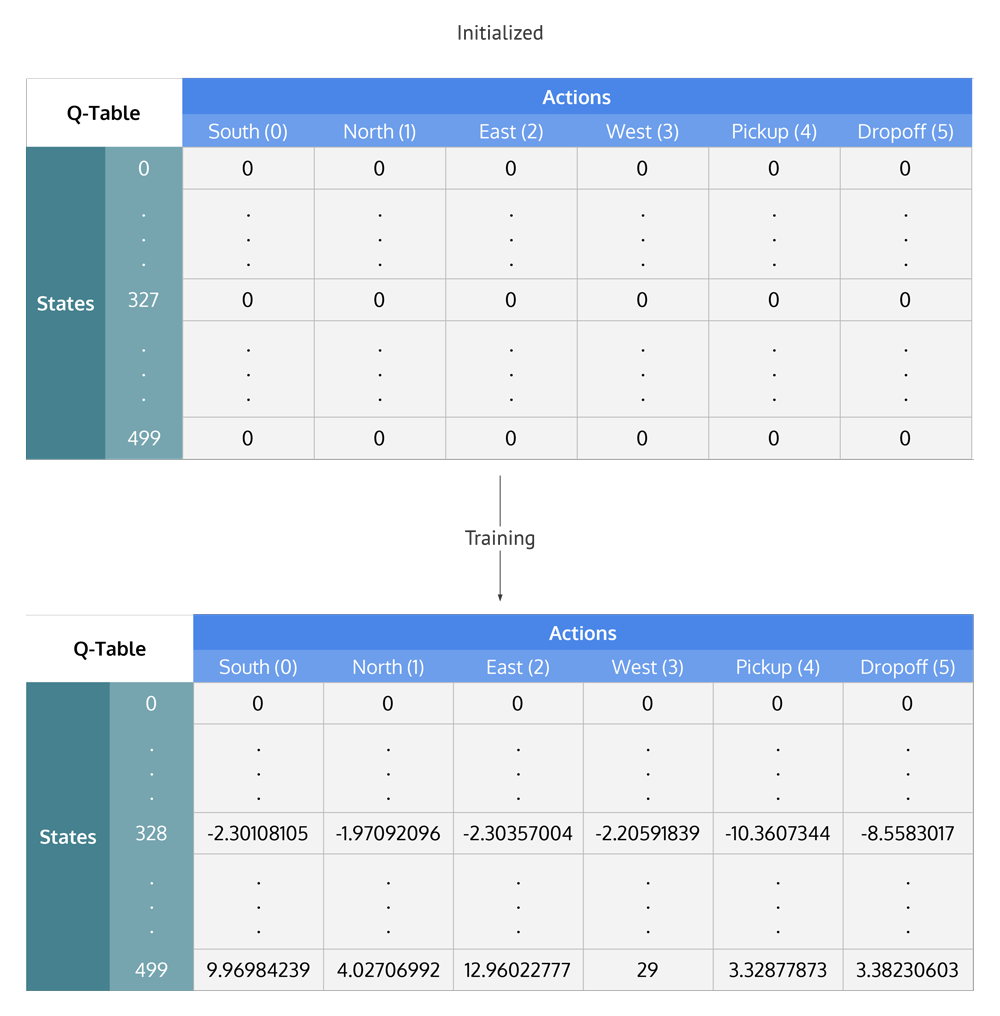

Q-Table values are initialized to zero and then updated during training to values that optimize the agent's traversal through the environment for maximum rewards

**Summing up the Q-Learning Process**

Breaking it down into steps, we get

* Initialize the Q-table by all zeros.
* Start exploring actions: For each state, select any one among all possible actions for the current state (S).
* Travel to the next state (S') as a result of that action (a).
* For all possible actions from the state (S') select the one with the highest Q-value.
* Update Q-table values using the equation.
* Set the next state as the current state.
* If goal state is reached, then end and repeat the process.

**Exploiting learned values**

After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called
 "epsilon" to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.


**Implementing Q-learning in python**

**Training the Agent**

First, we'll initialize the Q-table to a 500 x 6 matrix of zeros:

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

We can now create the training algorithm that will update this Q-table as the agent explores the environment over thousands of episodes.

In the first part of while not done, we decide whether to pick a random action or to exploit the already computed Q-values. This is done simply by using the epsilon value and comparing it to the random.uniform(0, 1) function, which returns an arbitrary number between 0 and 1.

We execute the chosen action in the environment to obtain the next_state and the reward from performing the action. After that, we calculate the maximum Q-value for the actions corresponding to the next_state, and with that, we can easily update our Q-value to the new_q_value:

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Now that the Q-table has been established over 100,000 episodes, let's see what the Q-values are at our illustration's state:

In [ ]:
q_table[328]

The max Q-value is "north" (-1.971), so it looks like Q-learning has effectively learned the best action to take in our illustration's state!

**Evaluating the agent**

Let's evaluate the performance of our agent. We don't need to explore actions any further, so now the next action is always selected using the best Q-value:

In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

We can see from the evaluation, the agent's performance improved significantly and it incurred no penalties, which means it performed the correct pickup/dropoff actions with 100 different passengers.

**Comparing our Q-learning agent to no Reinforcement Learning**

With Q-learning agent commits errors initially during exploration but once it has explored enough (seen most of the states), it can act wisely maximizing the rewards making smart moves. Let's see how much better our Q-learning solution is when compared to the agent making just random moves.

We evaluate our agents according to the following metrics,

* Average number of penalties per episode: The smaller the number, the better the performance of our agent. Ideally, we would like this metric to be zero or very close to zero.
* Average number of timesteps per trip: We want a small number of timesteps per episode as well since we want our agent to take minimum steps(i.e. the shortest path) to reach the destination.
* Average rewards per move: The larger the reward means the agent is doing the right thing. That's why deciding rewards is a crucial part of Reinforcement Learning. In our case, as both timesteps and penalties are negatively rewarded, a higher average reward would mean that the agent reaches the destination as fast as possible with the least penalties"

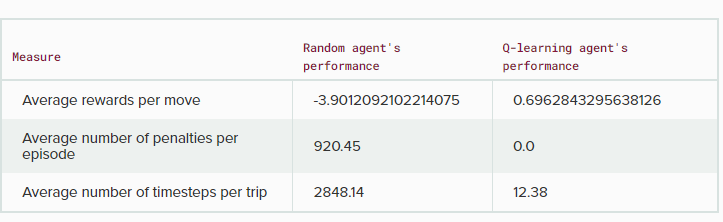

These metrics were computed over 100 episodes. And as the results show, our Q-learning agent nailed it!

**Hyperparameters and optimizations**

The values of `alpha`, `gamma`, and `epsilon` were mostly based on intuition and some "hit and trial", but there are better ways to come up with good values.

Ideally, all three should decrease over time because as the agent continues to learn, it actually builds up more resilient priors;

* alpha: (the learning rate) should decrease as you continue to gain a larger and larger knowledge base.
* gamma: as you get closer and closer to the deadline, your preference for near-term reward should increase, as you won't be around long enough to get the long-term reward, which means your gamma should decrease.
* epsilon: as we develop our strategy, we have less need of exploration and more exploitation to get more utility from our policy, so as trials increase, epsilon should decrease.

**Tuning the hyperparameters**

A simple way to programmatically come up with the best set of values of the hyperparameter is to create a comprehensive search function (similar to grid search) that selects the parameters that would result in best reward/time_steps ratio. The reason for reward/time_steps is that we want to choose parameters which enable us to get the maximum reward as fast as possible. We may want to track the number of penalties corresponding to the hyperparameter value combination as well because this can also be a deciding factor (we don't want our smart agent to violate rules at the cost of reaching faster). A more fancy way to get the right combination of hyperparameter values would be to use Genetic Algorithms.